In [53]:
import pandas as pd
import torch
import ltn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler

### 1. Initial data analysis

In [54]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)
data_info = data.info()
data_head = data.head()
data_description = data.describe()
(data_info, data_head, data_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59442 entries, 0 to 59441
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _time                       59442 non-null  object 
 1   GARAGE_EXTERNAL_POWER       59442 non-null  float64
 2   DEMAND_LIMIT                59442 non-null  float64
 3   DEMAND_LIMIT_INDICATOR      59442 non-null  float64
 4   BATTERY_SOC                 59442 non-null  float64
 5   BATTERY_DISCHARGE_POWER     59442 non-null  float64
 6   BATTERY_CHARGED_ENERGY      59442 non-null  float64
 7   BATTERY_DISCHARGED_ENERGY   59442 non-null  float64
 8   PV_POWER                    59442 non-null  float64
 9   PV_ENERGY                   59442 non-null  float64
 10  WALLBOX_ALPHA_ENERGY        59442 non-null  float64
 11  WALLBOX_ALPHA_POWER         59442 non-null  float64
 12  WALLBOX_1_ENERGY            59442 non-null  float64
 13  WALLBOX_1_POWER             594

(None,
                        _time  GARAGE_EXTERNAL_POWER  DEMAND_LIMIT  \
 0  2023-10-05 00:01:00+00:00               1.244171          50.0   
 1  2023-10-05 00:02:00+00:00               1.244171          50.0   
 2  2023-10-05 00:03:00+00:00               1.244171          50.0   
 3  2023-10-05 00:04:00+00:00               1.244171          50.0   
 4  2023-10-05 00:05:00+00:00               1.244171          50.0   
 
    DEMAND_LIMIT_INDICATOR  BATTERY_SOC  BATTERY_DISCHARGE_POWER  \
 0                     1.0         40.5                   -0.338   
 1                     1.0         40.5                   -0.372   
 2                     1.0         40.5                   -0.393   
 3                     1.0         40.5                   -0.339   
 4                     1.0         40.5                   -0.371   
 
    BATTERY_CHARGED_ENERGY  BATTERY_DISCHARGED_ENERGY  PV_POWER  PV_ENERGY  \
 0                     0.0                        0.0  0.008693        0.0   
 1   

In [ ]:
# Rule 1: SOC > 80%
mask_soc_above_80 = data['BATTERY_SOC'] > 80

# Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_40_to_80_high_power = (data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] < 80) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3a: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_below_40_high_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3b: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
mask_below_40_low_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] < data['DEMAND_LIMIT'])

# Rule 4: SOC < 15%
mask_below_15 = data['BATTERY_SOC'] < 15


data_soc_above_80 = data[mask_soc_above_80]
data_40_to_80_high_power = data[mask_40_to_80_high_power]
data_below_40_high_power = data[mask_below_40_high_power]
data_below_40_low_power = data[mask_below_40_low_power]
data_below_15 = data[mask_below_15]
count_rules = {
    "SOC > 80%": len(data_soc_above_80),
    "40% < SOC < 80% and High Power": len(data_40_to_80_high_power),
    "SOC < 40% and High Power": len(data_below_40_high_power),
    "SOC < 40% and Low Power": len(data_below_40_low_power),
    "SOC < 15%": len(data_below_15)
}

count_rules


In [ ]:
counts_df = pd.DataFrame(list(count_rules.items()), columns=['Rule', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(counts_df['Rule'], counts_df['Count'], color='skyblue')
plt.xlabel('SOC Rules')
plt.ylabel('Number of Entries')
plt.title('Distribution of Entries by SOC Rules')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

plt.show()


In [ ]:
total_entries_covered = sum(count_rules.values())
total_entries_covered

In [ ]:
len(data)

In [ ]:
print("Total Entries Covered by Rules: ", total_entries_covered *100/(len(data)) )

### 2. Create new datset  which corresponds to the following ground rules 

In [ ]:
# Combine all the filtered datasets into one that satisfies any of the rules
combined_data = pd.concat([
    data_soc_above_80,
    data_40_to_80_high_power,
    data_below_40_high_power,
    data_below_40_low_power,
    data_below_15
])
# Drop duplicate entries if any entry matches multiple rules
combined_data = combined_data.drop_duplicates()
# Save the combined dataset to a new CSV file
output_file_path = 'Filtered_Emobility_Data.csv'
combined_data.to_csv(output_file_path, index=False)




In [ ]:
data_modified = pd.read_csv(output_file_path)

In [ ]:
# Define the rules based on SOC
def evaluate_rules(df):
    # Rule 1: SOC > 80%
    rule1 = (df['BATTERY_SOC'] > 80)
    # Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule2 = (df['BATTERY_SOC'] > 40) & (df['BATTERY_SOC'] < 80) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])
    # Rule 3: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule3 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])
    # Rule 4: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
    rule4 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] < df['DEMAND_LIMIT'])
    # Rule 5: SOC < 15% (Battery discharging stopped)
    rule5 = (df['BATTERY_SOC'] < 15)
    rule1_sat = rule1.mean()
    rule2_sat = rule2.mean()
    rule3_sat = rule3.mean()
    rule4_sat = rule4.mean()
    rule5_sat = rule5.mean()

    return {
        "Rule 1 (SOC > 80%)": rule1_sat,
        "Rule 2 (40% < SOC < 80%)": rule2_sat,
        "Rule 3 (SOC < 40% and POWER > LIMIT)": rule3_sat,
        "Rule 4 (SOC < 40% and POWER < LIMIT)": rule4_sat,
        "Rule 5 (SOC < 15%)": rule5_sat
    }
rule_satisfaction = evaluate_rules(data_modified)
rule_satisfaction


### 3. Checking on whole dataset

In [ ]:
rule_satisfaction = evaluate_rules(data)
rule_satisfaction


### 4. Rules satisfaction wirh LTN

In [ ]:
import ltn.fuzzy_ops as fuzzy_ops

In [ ]:
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 4),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return model(inputs)
# Define the logical rules
def rule1():
    condition = soc_tensor > 80
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 0])
def rule2():
    condition = (soc_tensor > 40) & (soc_tensor < 80) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 1])
def rule3a():
    condition = (soc_tensor < 40) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 2])
def rule3b():
    condition = (soc_tensor < 40) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 3])
def rule4():
    condition = soc_tensor < 15
    return torch.mean(condition.float() * (1 - conditions(soc_tensor, external_power_tensor, demand_limit_tensor).sum(dim=1)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3a = rule3a()
    satisfaction_rule3b = rule3b()
    satisfaction_rule4 = rule4()
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3a, satisfaction_rule3b, satisfaction_rule4]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Satisfaction Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")


In [ ]:
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 4),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return model(inputs)
# Define the logical rules
def rule1():
    condition = soc_tensor > 85
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 0])
def rule2():
    condition = (soc_tensor > 35) & (soc_tensor < 85) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 1])
def rule3a():
    condition = (soc_tensor < 35) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 2])
def rule3b():
    condition = (soc_tensor < 35) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 3])
def rule4():
    condition = soc_tensor < 10
    return torch.mean(condition.float() * (1 - conditions(soc_tensor, external_power_tensor, demand_limit_tensor).sum(dim=1)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3a = rule3a()
    satisfaction_rule3b = rule3b()
    satisfaction_rule4 = rule4()
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3a, satisfaction_rule3b, satisfaction_rule4]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Satisfaction Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")


### 4. Tourch NN

In [ ]:
data['label'] = 0
data.loc[data['BATTERY_SOC'] > 80, 'label'] = 1
data.loc[(data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] <= 80) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT']), 'label'] = 2
data.loc[(data['BATTERY_SOC'] <= 40) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT']), 'label'] = 2
data.loc[(data['BATTERY_SOC'] <= 40) & (data['GARAGE_EXTERNAL_POWER'] < data['DEMAND_LIMIT']), 'label'] = 3
data.loc[data['BATTERY_SOC'] < 15, 'label'] = 4

In [ ]:
print(data.columns)

In [ ]:
features = data[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT', 'BATTERY_DISCHARGE_POWER', 'PV_POWER', 'WALLBOX_ALPHA_POWER']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
class BatteryNN(nn.Module):
    def __init__(self):
        super(BatteryNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  
        )
    def forward(self, x):
        return self.network(x)

In [ ]:
model = BatteryNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

In [ ]:
def train(model, features, targets, batch_size=64, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_x = features[start:end]
            batch_y = targets[start:end]
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        average_loss = running_loss / (len(features) / batch_size)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}')

# Test function
def test(model, features, targets, batch_size=64):
    model.eval()
    total = correct = 0
    with torch.no_grad():
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_x = features[start:end]
            batch_y = targets[start:end]
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
# Execute training and testing
train(model, X_train, y_train)
test(model, X_test, y_test)

### 5. An attemp to execute some rules and estimate accuracy


In [75]:

SOC = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).reshape(-1, 1)
GARAGE_EXTERNAL_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).reshape(-1, 1)
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).reshape(-1, 1)

high_threshold = torch.nn.Parameter(torch.tensor([0.8]))
mid_threshold_low = torch.nn.Parameter(torch.tensor([0.4]))
mid_threshold_high = torch.nn.Parameter(torch.tensor([0.8]))
low_threshold = torch.nn.Parameter(torch.tensor([0.4]))
very_low_threshold = torch.nn.Parameter(torch.tensor([0.15]))

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def greater_than(x, threshold):
    return sigmoid(10 * (x - threshold))

def less_than(x, threshold):
    return 1 - greater_than(x, threshold)

def between(x, low, high):
    return greater_than(x, low) * less_than(x, high)

def is_high_SOC(soc):
    return greater_than(soc, high_threshold)

def is_mid_SOC(soc):
    return between(soc, mid_threshold_low, mid_threshold_high)

def is_low_SOC(soc):
    return less_than(soc, low_threshold)

def is_very_low_SOC(soc):
    return less_than(soc, very_low_threshold)

def power_above_demand(power, demand):
    return greater_than(power, demand)

def battery_management_logic(soc, power, demand):
    high_soc_rule = is_high_SOC(soc)
    mid_soc_rule = is_mid_SOC(soc) * power_above_demand(power, demand)
    low_soc_rule = is_low_SOC(soc) * ((power_above_demand(power, demand) + (1 - power_above_demand(power, demand))) / 2)
    very_low_soc_rule = is_very_low_SOC(soc)
    return high_soc_rule * mid_soc_rule * low_soc_rule * very_low_soc_rule
optimizer = optim.Adam([high_threshold, mid_threshold_low, mid_threshold_high, low_threshold, very_low_threshold], lr=0.01)

def train():
    for step in range(1000):
        optimizer.zero_grad()
        logic_output = battery_management_logic(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT)
        loss = 1 - logic_output.mean()  # Objective to maximize the logical satisfaction
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

train()

print("Optimized Thresholds:")
print(f"High Threshold: {high_threshold.item()}")
print(f"Mid Threshold Low: {mid_threshold_low.item()}")
print(f"Mid Threshold High: {mid_threshold_high.item()}")
print(f"Low Threshold: {low_threshold.item()}")
print(f"Very Low Threshold: {very_low_threshold.item()}")


Step 0, Loss: 1.0
Step 100, Loss: 1.0
Step 200, Loss: 1.0
Step 300, Loss: 1.0
Step 400, Loss: 1.0
Step 500, Loss: 1.0
Step 600, Loss: 1.0
Step 700, Loss: 1.0
Step 800, Loss: 1.0
Step 900, Loss: 1.0
Optimized Thresholds:
High Threshold: 0.800000011920929
Mid Threshold Low: 0.4000000059604645
Mid Threshold High: 0.800000011920929
Low Threshold: 0.4000000059604645
Very Low Threshold: 0.15000000596046448


In [ ]:
data['BATTERY_SOC_normalized'] = data['BATTERY_SOC'] / 100
data['GARAGE_EXTERNAL_POWER_normalized'] = data['GARAGE_EXTERNAL_POWER'] / data['GARAGE_EXTERNAL_POWER'].max()

# Convert to tensors
soc_tensor = torch.tensor(data['BATTERY_SOC_normalized'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER_normalized'].values, dtype=torch.float32)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 10)  
        self.fc2 = nn.Linear(10, 10) 
        self.fc3 = nn.Linear(10, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        return x


In [ ]:
# Instantiate the MLPs
high_soc_mlp = MLP()
external_gt_demand_mlp = MLP()
soc_var = ltn.Variable('soc', soc_tensor)
external_power_var = ltn.Variable('external_power', external_power_tensor)
HighSOC = ltn.Predicate(high_soc_mlp)
ExternalGreaterThanDemand = ltn.Predicate(external_gt_demand_mlp)


In [ ]:
def Implies(p, q):
    return torch.min(p, 1-q)
def Forall(variables, formula):
    return torch.mean(formula(variables))


In [ ]:
formula = ltn.Forall(soc_var, ltn.Implies(HighSOC(soc_var), ExternalGreaterThanDemand(external_power_var)))
kb = ltn.KnowledgeBase("battery_management", formula)

In [ ]:
optimizer = torch.optim.Adam(kb.parameters(), lr=0.01)
for epoch in range(1000):
    optimizer.zero_grad()
    loss = -kb()  # Minimize the negative of the KB, which maximizes the satisfaction of the KB
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


In [ ]:
with torch.no_grad():
    soc_high = HighSOC(soc_var)
    external_gt_demand = ExternalGreaterThanDemand(external_power_var)
print("High SOC Evaluation:", soc_high.mean().item())
print("External Power Greater Than Demand Evaluation:", external_gt_demand.mean().item())


In [55]:

soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
# Ensure tensors do not require gradients
soc_tensor.requires_grad_(False)
power_tensor.requires_grad_(False)
demand_tensor.requires_grad_(False)

class IsDischarging(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = nn.Parameter(torch.tensor([-0.5], dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(-x - self.threshold)

class ExceedsDemand(nn.Module):
    def forward(self, power, demand):
        return torch.relu(power - demand)

class SOCRange(nn.Module):
    def __init__(self, low, high):
        super().__init__()
        self.low = nn.Parameter(torch.tensor([low], dtype=torch.float32))
        self.high = nn.Parameter(torch.tensor([high], dtype=torch.float32))

    def forward(self, soc):
        return torch.sigmoid(soc - self.low) * torch.sigmoid(self.high - soc)

# Instantiate predicates
is_discharging = IsDischarging()
exceeds_demand = ExceedsDemand()
soc_high = SOCRange(80, 100)  # Adjust high to a realistic maximum if 'inf' is inappropriate
soc_mid = SOCRange(40, 80)
soc_low = SOCRange(0, 40)
soc_very_low = SOCRange(0, 15)

def rule1(soc, power):
    return soc_high(soc) * is_discharging(power)

def rule2(soc, power, demand):
    return soc_mid(soc) * exceeds_demand(power, demand) * is_discharging(power)

def rule3(soc, power, demand):
    return soc_low(soc) * exceeds_demand(power, demand) * is_discharging(power)

def rule4(soc, power, demand):
    return soc_low(soc) * (1 - exceeds_demand(power, demand)) * (1 - is_discharging(power))

def rule5(soc, power):
    return soc_very_low(soc) * (1 - is_discharging(power))

optimizer = optim.Adam([
    {'params': is_discharging.parameters()},
    {'params': exceeds_demand.parameters()},
    {'params': soc_high.parameters()},
    {'params': soc_mid.parameters()},
    {'params': soc_low.parameters()},
    {'params': soc_very_low.parameters()}
], lr=0.01)

for epoch in range(500):
    optimizer.zero_grad()
    loss =   (rule1(soc_tensor, power_tensor) +
              rule2(soc_tensor, power_tensor, demand_tensor) +
              rule3(soc_tensor, power_tensor, demand_tensor) +
              rule4(soc_tensor, power_tensor, demand_tensor) +
              rule5(soc_tensor, power_tensor)).mean()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")
# Print learned parameters for inspection
print("Learned SOC high threshold:", soc_high.high.item())
print("Learned SOC mid range:", soc_mid.low.item(), soc_mid.high.item())
print("Learned SOC low range:", soc_low.low.item(), soc_low.high.item())


Epoch 0, Loss: 0.27480098605155945
Epoch 1, Loss: 0.2731574475765228
Epoch 2, Loss: 0.2715201675891876
Epoch 3, Loss: 0.269889235496521
Epoch 4, Loss: 0.2682651877403259
Epoch 5, Loss: 0.2666480839252472
Epoch 6, Loss: 0.26503801345825195
Epoch 7, Loss: 0.263435035943985
Epoch 8, Loss: 0.2618391811847687
Epoch 9, Loss: 0.2602510154247284
Epoch 10, Loss: 0.2586701214313507
Epoch 11, Loss: 0.2570970356464386
Epoch 12, Loss: 0.25553175806999207
Epoch 13, Loss: 0.2539748549461365
Epoch 14, Loss: 0.2524259090423584
Epoch 15, Loss: 0.2508854269981384
Epoch 16, Loss: 0.24935337901115417
Epoch 17, Loss: 0.24782991409301758
Epoch 18, Loss: 0.24631494283676147
Epoch 19, Loss: 0.24480858445167542
Epoch 20, Loss: 0.243310809135437
Epoch 21, Loss: 0.24182213842868805
Epoch 22, Loss: 0.24034257233142853
Epoch 23, Loss: 0.23887215554714203
Epoch 24, Loss: 0.23741084337234497
Epoch 25, Loss: 0.23595871031284332
Epoch 26, Loss: 0.2345157414674759
Epoch 27, Loss: 0.2330823838710785
Epoch 28, Loss: 0.231

In [56]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [57]:
model_high_soc = SimpleMLP(input_dim=1)
model_medium_soc = SimpleMLP(input_dim=1)
model_low_soc = SimpleMLP(input_dim=1)
model_very_low_soc = SimpleMLP(input_dim=1)
model_power_above = SimpleMLP(input_dim=1)
# Recreate the model with the correct input dimension
model_power_above = SimpleMLP(input_dim=2)  # Adjusted from 1 to 2

In [58]:
# Assuming GARAGE_POWER and DEMAND_LIMIT are already tensors and have been unsqueezed properly
power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())


In [60]:
def custom_implies(p, q):
    """ Implements logical implication using tensors: p → q is ¬p ∨ q """
    return torch.logical_or(~p.bool(), q.bool())
SOC = torch.tensor(data['BATTERY_SOC'].values).float() / 100
GARAGE_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values).float()
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values).float()
# Example of a condition: SOC > 0.8 (high SOC)
high_soc_output = model_high_soc(SOC.unsqueeze(1))
high_soc_condition = (SOC > 0.8).unsqueeze(1)
high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
# Continue from previous definitions
# Middle SOC Condition: 40% < SOC < 80%
medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)  # Ensure target condition has the same shape as output
medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
# If GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)  # Match the shape
power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
# Low SOC Condition: SOC < 40%
low_soc_output = model_low_soc(SOC.unsqueeze(1))
low_soc_condition = (SOC < 0.4).unsqueeze(1)  # Ensure target condition has the same shape as output
low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
# Very Low SOC Condition: SOC < 15%
very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
very_low_soc_condition = (SOC < 0.15).unsqueeze(1)  # Match the shape
very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [63]:
def calculate_accuracy(outputs, targets):
    predicted = outputs.round()  # Round to 0 or 1
    correct = (predicted == targets).float()  # Correct predictions
    accuracy = correct.sum() / len(correct)  # Mean accuracy
    return accuracy


In [64]:

accuracies = []
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    # Recalculate each output inside the loop
    high_soc_output = model_high_soc(SOC.unsqueeze(1))
    medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
    power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
    low_soc_output = model_low_soc(SOC.unsqueeze(1))
    very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
    # Recalculate conditions
    high_soc_condition = (SOC > 0.8).unsqueeze(1)
    medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)
    power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
    low_soc_condition = (SOC < 0.4).unsqueeze(1)
    very_low_soc_condition = (SOC < 0.15).unsqueeze(1)
    # Recalculate losses
    high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
    medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
    power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
    low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
    very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())
    # Combine all losses
    total_loss = (high_soc_loss + medium_soc_loss + power_above_loss + low_soc_loss + very_low_soc_loss)
    total_loss.backward()
    optimizer.step()
    # Calculate accuracy for each model
    high_soc_accuracy = calculate_accuracy(high_soc_output, high_soc_condition.float())
    medium_soc_accuracy = calculate_accuracy(medium_soc_output, medium_soc_condition.float())
    power_above_accuracy = calculate_accuracy(power_above_output, power_above_condition.float())
    low_soc_accuracy = calculate_accuracy(low_soc_output, low_soc_condition.float())
    very_low_soc_accuracy = calculate_accuracy(very_low_soc_output, very_low_soc_condition.float())
    # Aggregate accuracies and losses
    mean_accuracy = np.mean([high_soc_accuracy.item(), medium_soc_accuracy.item(), 
                             power_above_accuracy.item(), low_soc_accuracy.item(), 
                             very_low_soc_accuracy.item()])
    accuracies.append(mean_accuracy)
    losses.append(total_loss.item())

    print(f"Epoch {epoch}, Loss: {total_loss.item()}, Mean Accuracy: {mean_accuracy}")
# Calculate final mean accuracy and satisfaction
final_mean_accuracy = np.mean(accuracies)
final_mean_loss = np.mean(losses)
print(f"Final Mean Accuracy: {final_mean_accuracy}, Final Mean Loss (Satisfaction): {final_mean_loss}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [66]:
# Define the Predicate Neural Network
class Predicate(nn.Module):
    def __init__(self, input_dim, hidden_dim=10):
        super(Predicate, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Create instances for different SOC levels
IsHighSOC = Predicate(input_dim=1)
IsLowSOC = Predicate(input_dim=1)


In [73]:
# Extract BATTERY_SOC values and convert them to a tensor
soc_real_values = torch.tensor(data['BATTERY_SOC'].values).float().reshape(-1, 1)
# Define labels based on the SOC thresholds for training
real_high_soc_labels = torch.where(soc_real_values > 80, 1, 0)  # High if SOC > 80
real_low_soc_labels = torch.where(soc_real_values < 40, 1, 0)   # Low if SOC < 20

/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)  # Ensure data is a float32 tensor
/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are float32 tensor


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1, Loss: 9.681702661801239e-11
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ext

/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  soc_values = torch.tensor(soc_values, dtype=torch.float32)  # Ensure it's a tensor


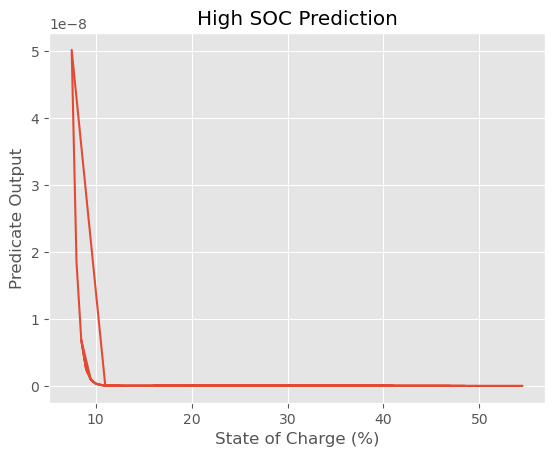

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


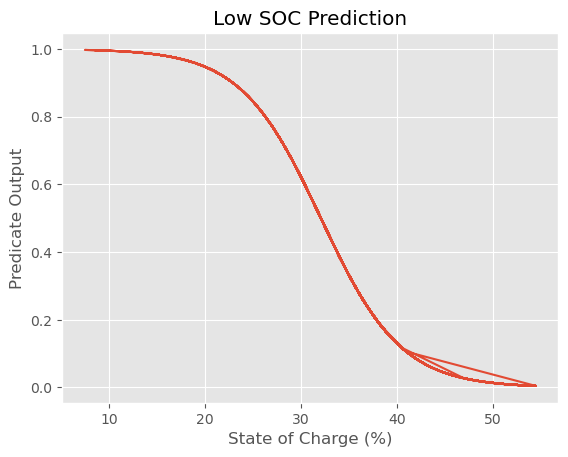

In [74]:
def train(model, data, labels, epochs=100, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    data = torch.tensor(data, dtype=torch.float32)  # Ensure data is a float32 tensor
    labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are float32 tensor

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')


def plot_model_predictions(model, soc_values, title):
    soc_values = torch.tensor(soc_values, dtype=torch.float32)  # Ensure it's a tensor
    with torch.no_grad():
        preds = model(soc_values).numpy()
    plt.plot(soc_values.numpy(), preds, label='Model Output')
    plt.title(title)
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Predicate Output')
    plt.show()

# Example usage
# soc_real_values should be your actual SOC data loaded and preprocessed as a tensor
# high_soc_labels and low_soc_labels should be defined based on your criteria
train(IsHighSOC, soc_real_values, real_high_soc_labels)
train(IsLowSOC, soc_real_values, real_low_soc_labels)
plot_model_predictions(IsHighSOC, soc_real_values, 'High SOC Prediction')
plot_model_predictions(IsLowSOC, soc_real_values, 'Low SOC Prediction')


In [72]:
# Train the models on this actual dataset
train(IsHighSOC, soc_real_values, real_high_soc_labels)
train(IsLowSOC, soc_real_values, real_low_soc_labels)

/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1677067017.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)  # Ensure data is a float32 tensor
/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1677067017.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are float32 tensor


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1, Loss: 1.2154389139595878e-07
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex